# 期末大作业

In [1]:
from PIL import Image
import os
import torch
import cv2
import random
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision.models import resnet50
from torchvision import transforms
import torch.nn.functional as functions
from transformers import BertTokenizer, BertModel, ViTFeatureExtractor, ViTModel
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Task1 数据处理与数据集搭建

### 数据读取

In [2]:
all_posters_filename = os.listdir('./poster')
all_posters_index = sorted([int(x[:-4]) for x in all_posters_filename])
all_posters_filename = [f'{i}.jpg' for i in all_posters_index]
df_movie_info = pd.read_csv('info.csv', index_col=0).loc[all_posters_index, ['name', 'intro']]
df_movie_info.head(5)

,name,intro
id,,
1,Toy Story (1995),A cowboy doll is profoundly threatened and jea...
2,Jumanji (1995),When two kids find and play a magical board ga...
3,Grumpier Old Men (1995),John and Max resolve to save their beloved bai...
4,Waiting to Exhale (1995),"Based on Terry McMillan's novel, this film fol..."
5,Father of the Bride Part II (1995),George Banks must deal not only with the pregn...


In [3]:
movie_intros = df_movie_info.loc[:, 'intro'].tolist()
movie_names = df_movie_info.loc[:, 'name'].tolist()

Everything You Always Wanted to Know About Sex * But Were Afraid to Ask (1972) 
Seven stories are trying to answer the question: what is sex? Or maybe they are not trying.


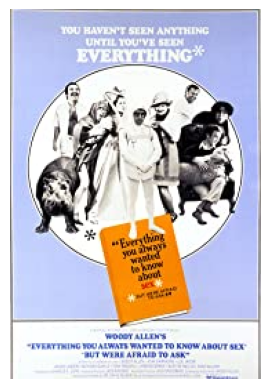

In [4]:
# 检查预处理完成后海报和简介数据的索引是否能够对应
index_for_test = random.randint(0, len(all_posters_index) - 1)

print(movie_names[index_for_test])
print(movie_intros[index_for_test])

poster = cv2.imread(f'./poster/{all_posters_filename[index_for_test]}')
poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
plt.imshow(poster)
plt.axis('off')
plt.show()

### 划分训练集和测试集

In [6]:
with open('train.txt', 'r') as f:
    lines = f.readlines()
    train_idx = [int(line.strip()) for line in lines]

posters_train = [all_posters_filename[i] for i in train_idx]
posters_test = all_posters_filename.copy()
intros_train = [movie_intros[i] for i in train_idx]
intros_test = movie_intros.copy()

# Here elements in posters_train and posters_test are actually filenames, not vectors
print(len(posters_train), len(posters_test), len(intros_train), len(intros_test))

1762 2938 1762 2938


### 搭建数据集，对数据进行预处理

In [7]:
class MovieLensDataset(Dataset):
    def __init__(self, data_root, posters, intros, transform, **kwargs):
        self.data_root = data_root
        self.posters = posters
        self.intros = intros
        self.transform = transform
    
    def __len__(self):
        return len(self.posters)
    
    def __getitem__(self, index):
        
        poster_path = os.path.join(self.data_root, self.posters[index])
        poster = self.process_poster(poster_path)
        # 将intro转换为小写，使其能被BERT处理
        intro = self.intros[index].lower()

        return poster, intro

    def process_poster(self, path, **kwargs):

        poster = cv2.imread(path)
        poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
        # 对海报进行预处理，使之符合ViT的输入要求
        poster = Image.fromarray(poster)  # 转换为 PIL.Image
        poster_processed = self.transform(poster)

        return poster_processed

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

data_root = './poster'
dataset_train =MovieLensDataset(
    data_root=data_root,
    posters=posters_train,
    intros=intros_train,
    transform = transform
)
dataset_test = MovieLensDataset(
    data_root=data_root,
    posters=posters_test,
    intros=intros_test,
    transform = transform
)

In [8]:
train_dataloader = DataLoader(dataset_train, batch_size=128, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=256)

## Task2 模型设计与训练

### 定义模型

In [9]:
class MyModel(nn.Module):
    def __init__(self, **kwargs):
        super(MyModel, self).__init__()

        self.t = nn.Parameter(torch.tensor(1.0))
        

        # 初始化图片encoder：使用预训练的ViT
        self.poster_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224', do_rescale = False)
        self.poster_encoder = ViTModel.from_pretrained('google/vit-base-patch16-224')
        # 调整图片编码维度
        self.poster_fc = nn.Linear(self.poster_encoder.config.hidden_size, 128)
        

        # 初始化文本encoder：使用预训练的BERT
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        # # 调整文本编码的维度
        self.text_fc = nn.Linear(768, 128)


        self.poster_feature_extractor
        for param in self.poster_encoder.parameters():
            param.requires_grad = False
        
        for param in self.bert_model.parameters():
            param.requires_grad = False
        

    def forward(self, poster, intro):
        poster_input= self.poster_feature_extractor(images=poster, return_tensors="pt").to(device)
        poster_output = self.poster_encoder(**poster_input)
        poster_feature = poster_output.last_hidden_state[:, 0, :]
        poster_feature = self.poster_fc(poster_feature)
        
        intro_inputs = self.bert_tokenizer(intro, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
        intro_outputs = self.bert_model(**intro_inputs)
        intro_feature = intro_outputs.last_hidden_state[:, 0, :]
        intro_feature = self.text_fc(intro_feature)
        
        norm_poster_feature = functions.normalize(poster_feature, p=2, dim=1) 
        norm_intro_feature = functions.normalize(intro_feature, p=2, dim=1)
        logits = (norm_poster_feature @ norm_intro_feature.T) * torch.exp(self.t)
        
        return logits

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cpu':
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print("Using device:", device)
model_args = {}
model = MyModel(**model_args).to(device)

Using device: mps


/Users/peiyuliu/miniconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

def contrastive_loss(logits, n):
    labels = torch.arange(n).to(logits.device)
    loss_poster = functions.cross_entropy(logits, labels)
    loss_intro = functions.cross_entropy(logits.T, labels)
    loss = (loss_poster + loss_intro)/2
    return loss

### 模型训练与测试

In [12]:
# 模型训练示例，仅供演示，实际训练过程见文档
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for batch, (posters, intros) in enumerate(train_dataloader):
        posters = posters.to(device)
        optimizer.zero_grad()  # 清除旧的梯度
        logits = model(posters, intros)
        loss = contrastive_loss(logits, posters.shape[0])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss}")


Epoch 1, Loss: 4.691096476146153
Epoch 2, Loss: 4.253788096564157
Epoch 3, Loss: 4.006174223763602
Epoch 4, Loss: 3.8104643651417325
Epoch 5, Loss: 3.6367137091500417
Epoch 6, Loss: 3.474426337650844
Epoch 7, Loss: 3.3479413305010115
Epoch 8, Loss: 3.2028087036950246
Epoch 9, Loss: 3.070540819849287
Epoch 10, Loss: 2.9252038172313144


In [13]:
model = torch.load('model.pth')

In [14]:
def get_acc(D, ratio=0.05, dim=1):
    '''
    Calculate the accuracy based on the top-k nearest neighbors in the distance matrix.

    Parameters:
    D : torch.Tensor
        The distance matrix with shape (N, N), where 
        D[i, j] represents the distance between poster[i] and intro[j].
    ratio : float
        A float in the range (0, 1) that determines the proportion of nearest neighbors to consider. 
    dim : int
        The dimension along which to compute the top-k neighbors. 
        Use dim=1 for top-k intros for each poster, dim=0 for the top-k posters for each intro.
    '''

    total_samples = len(D)
    k = int(ratio * total_samples)

    _, topk_indices = D.topk(k, dim=dim, largest=False)
    if dim == 0:
        topk_indices = topk_indices.T
    
    correct_matches = 0
    train_correct_matches = 0
    test_not_in_train_correct_matches = 0
    for i in range(total_samples):
        if i in topk_indices[i]:
            correct_matches += 1
            if i in train_idx:
                train_correct_matches += 1
            else:
                test_not_in_train_correct_matches += 1

    accuracy = correct_matches / total_samples
    return accuracy, train_correct_matches, test_not_in_train_correct_matches

In [15]:
torch.mps.empty_cache()
full_poster_features = []
full_intro_features = []
model.eval()
for batch, (posters, intros) in enumerate(test_dataloader):
    posters = posters.to(device)
    poster_inputs = model.poster_feature_extractor(images=posters, return_tensors="pt").to(device)
    poster_outputs = model.poster_encoder(**poster_inputs)
    poster_features = poster_outputs.last_hidden_state[:, 0, :]
    poster_features = model.poster_fc(poster_features)
        
    intro_inputs = model.bert_tokenizer(intros, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    intro_outputs = model.bert_model(**intro_inputs)
    intro_features = intro_outputs.last_hidden_state[:, 0, :]
    intro_features = model.text_fc(intro_features)

    full_poster_features.append(poster_features)
    full_intro_features.append(intro_features)

full_poster_features = torch.cat(full_poster_features)
full_intro_features = torch.cat(full_intro_features)
D_test = torch.mm(full_poster_features, full_intro_features.T)
D_test = D_test / (torch.norm(full_poster_features, dim=1, keepdim=True) * torch.norm(full_intro_features, dim=1))
D_test = -D_test
accuracy1, train_correct_matches1, test_not_in_train_correct_matches1 = get_acc(D_test, ratio=0.05, dim=0)
print(f'Accuracy on dim 0: {accuracy1 * 100:.2f}%')
accuracy2, train_correct_matches2, test_not_in_train_correct_matches2 = get_acc(D_test, ratio=0.05, dim=1)
print(f'Accuracy on dim 1: {accuracy2 * 100:.2f}%')

print(f'Train dataset accuracy on dim 0: {train_correct_matches1 / len(train_idx) * 100:.2f}%')
print(f'Test dataset (excluding train dataset) accuracy on dim 0: {test_not_in_train_correct_matches1 / len(train_idx) * 100:.2f}%')
print(f'Train dataset accuracy on dim 1: {train_correct_matches2 / len(train_idx) * 100:.2f}%')
print(f'Test dataset (excluding train dataset) accuracy on dim 1: {test_not_in_train_correct_matches2 / (len(movie_intros) - len(train_idx)) * 100:.2f}%')

Accuracy on dim 0: 66.68%
Accuracy on dim 1: 67.43%
Train dataset accuracy on dim 0: 100.00%
Test dataset (excluding train dataset) accuracy on dim 0: 11.18%
Train dataset accuracy on dim 1: 99.94%
Test dataset (excluding train dataset) accuracy on dim 1: 18.71%


Text(0.5, 1.0, 'D_test')

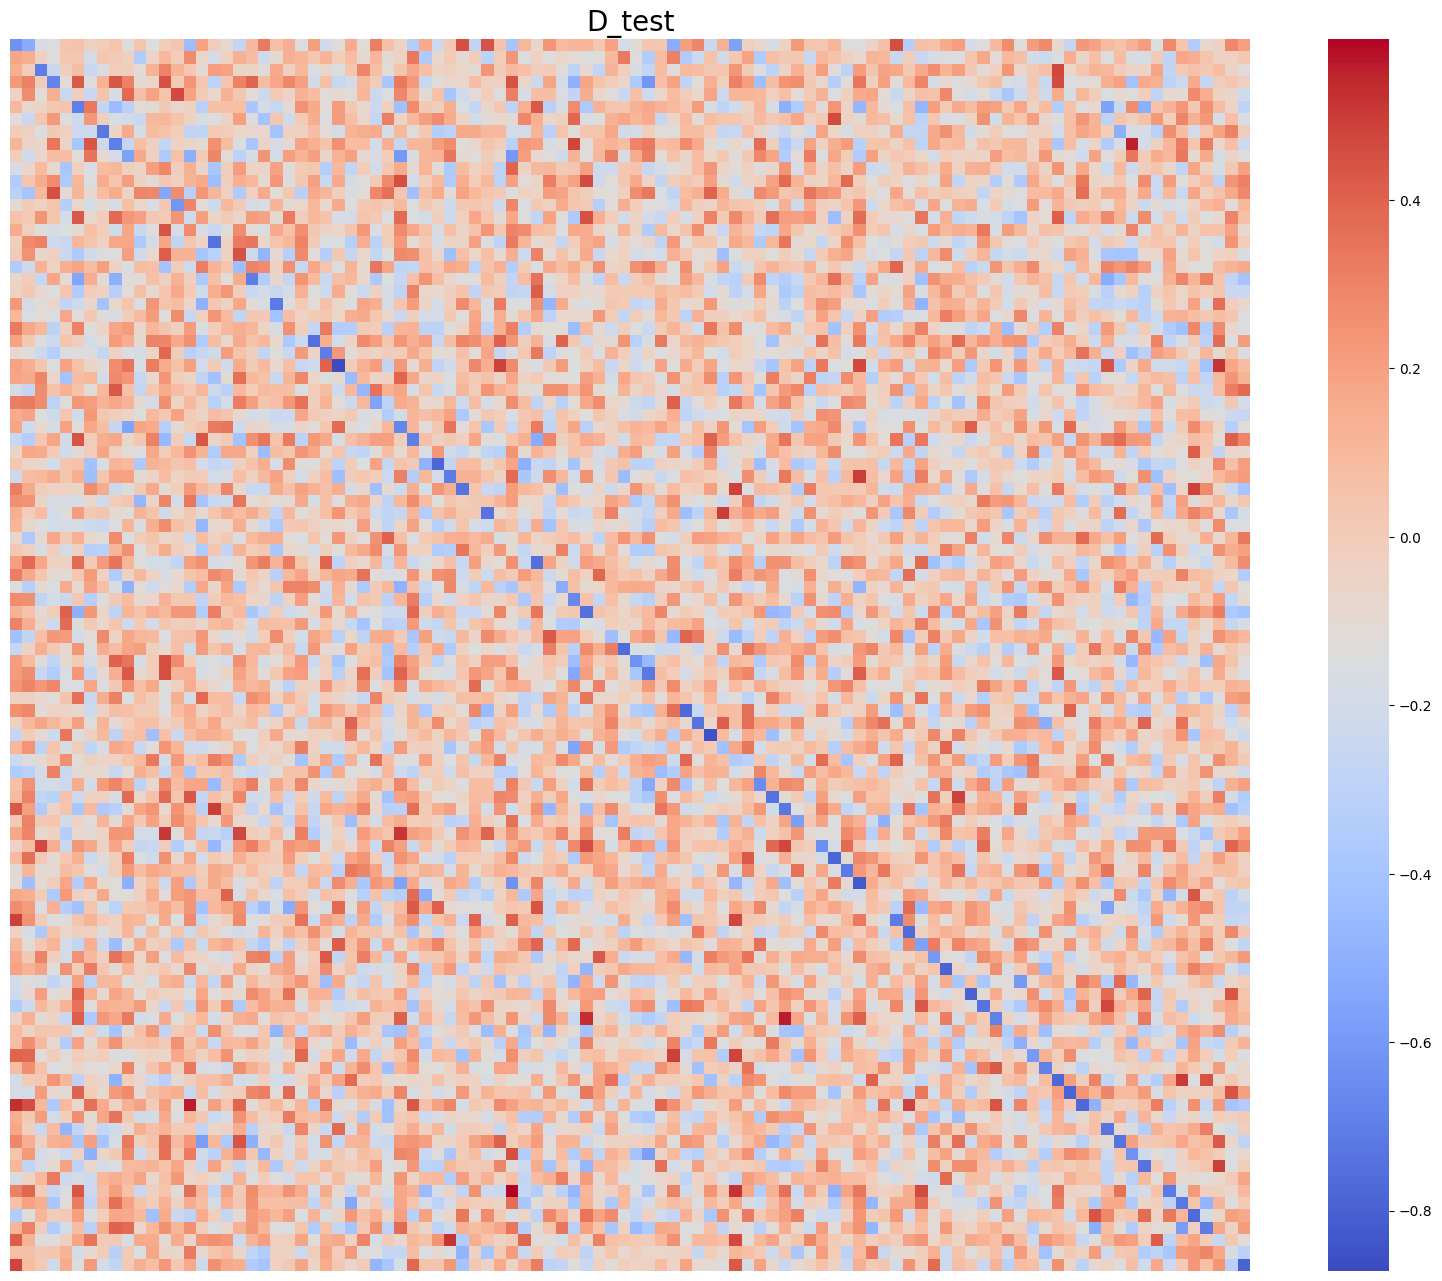

In [16]:
D_plot = D_test[0:100, 0:100].cpu().detach().numpy()
plt.figure(figsize=(20, 16))
sns.heatmap(D_plot, cmap='coolwarm', annot=False, fmt=".2f", xticklabels=False, yticklabels=False)
plt.xticks = []
plt.yticks = []
plt.title('D_test', fontsize=20)